<a href="https://colab.research.google.com/github/rahiakela/deep_learning_for_vision_systems/blob/5-advanced-cnn-architectures/2_alexnet_implementation_with_keras_using_cifar_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet implementation with Keras using CIFAR-10 dataset

The main motivation behind AlexNet was to build a deeper network that can learn more complex functions.

AlexNet was the winner of the ILSVRC image classification competition in 2012. Alex Krizhevsky, Geoffrey Hinton and Ilya Sutskever created a neural network architecture called ‘AlexNet’ in their paper “[ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)”.

They trained their network on 1.2 million high-resolution images into 1,000 different classes of the ImageNet dataset. AlexNet was state-of-the-art at its time because it was the first real “deep” network (back then) that opened the door for the computer vision community to seriously consider convolutional networks in their applications.

**AlexNet architecture**

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/alexnet-architecture.png?raw=1' width='800'/>

AlexNet has a lot of similarities to LeNet but it is much deeper (more hidden layers) and bigger (more filters per layer). They both have similar
building blocks of a series of CONV + POOL layers stacked on top of each other followed by FC layers and a Softmax. 

We’ve seen that LeNet has around 61 thousand parameters whereas AlexNet has about 60 million parameters and 650,000 neurons which gives it a larger learning capacity to understand more complex features. This allowed AlexNet to have a remarkable
performance in the ILSVRC image classification competition in 2012.

The architecture is pretty straightforward. It consists of:
* Convolutional layers with the following kernel sizes: 11x11, 5x5, and 3x3
* Max pooling layers for images downsampling
* Dropout layers to avoid overfitting
* Unlike LeNet, AlexNet authors used ReLU activation functions in the hidden layers and a softmax activation in the output layer

AlexNet is consists of five convolutional layers, some of which are followed by max-pooling layers, and three fully-connected layers with a final 1000-way softmax. 

You can represent the AlexNet architecture in text as follows:
**INPUT IMAGE => CONV1 => POOL2 => CONV3 => POOL4 => CONV5 => CONV6 => CONV7 => POOL8 => FC9=> FC10 => SOFTMAX7**





## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Activation, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from keras.datasets import cifar10

import numpy as np
import pandas as pd
import cv2 

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

## Novel features of AlexNet

Before AlexNet, deep learning was starting to gain traction in speech recognition and a few other areas. But AlexNet was the milestone that convinced a lot of the computer vision community to take a serious look at deep learning and demonstrate that deep learning really works in computer vision.

### ReLU activation function

AlexNet, proposed by Alex Krizhevsky, uses ReLu(Rectified Linear Unit) for the non-linear part, instead of a Tanh or Sigmoid functions that were the earlier standard for traditional neural networks (like LeNet), ReLu was used in the hidden layers of AlexNet architecture because it trains much faster. 

This is because the derivative of the sigmoid function becomes very small
in the saturating region and therefore the updates applied to the weights almost vanish. This phenomenon is called the vanishing gradient problem.

#### Vanishing gradient problem

Certain activation functions, like the sigmoid function, squishes a large input space into a small input space between 0 and 1 (-1 to 1 range for Tanh activations). Therefore, a large change in the input of the sigmoid function will cause a small change in the output. Which makes the derivative become very small.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/vanishing-gradient.png?raw=1' width='800'/>

### Local response normalization

In AlexNet, local response normalization is used. It is different from the batch normalization technique Normalization helps to speed up the convergence. Nowadays, batch normalization (BN) is used instead of using local response normalization.

### Weight regularization

Weight decay is another term for the L2 regularization technique. It is an approach to reduce the overfitting of a deep learning neural network models on the training data to allow it to generalize better on new data.

```python
model.add(Conv2D(32, (3,3), kernel_regularizer=l2(λ)))
```

The lambda value is the weight decay hyperparameter that you can tune. If you still see overfitting size, increase the lambda value to reduce overfitting. 

In this case, the authors found that a small decay value of 0.0005 was good enough for the model to learn.

## AlexNet implementation in Keras

AlexNet neural network contains eight weight layers: the first five are
convolutional and the remaining three are fully-connected. The output of the last fullyconnected layer is fed to a 1000-way softmax which produces a distribution over the 1000 class labels. 

<img src='//github.com/moelgendy/deep_learning_for_vision_systems/raw/fa42fcb4ed8f8eb57460eadad3a8cb9b7d167a05/chapter_05/images/alexnet_architecture.png?raw=1' width='800'/>

AlexNet input starts with 227x227x3 images. If you read the paper, you will notice that it refers to the dimensions volume of 224x224x3 for the input images. But the numbers make sense only for 227x227x3 images. I suggest that this could be a typing mistake in the paper.

The layers are stacked together as follows:

* **CONV1**: the authors used a large kernel size = 11. They also used a large stride = 4 which makes the input dimensions roughly shrink by a factor 4 (from 227x227 to 55x55).

Calculate the dimensions of the output as follows:

(227 - 11)/4+ 1 = 55 and the depth is the number of filters in the conv layer = 96

The output dimension = 55x55x96

* **POOL layer**: POOL layer with a filter size of 3x3 which reduces the dimensions from 55x55 to 27x27.

Calculate the dimensions of the output as follows:

(55 - 3)/2+ 1 = 27. The pooling layer doesn’t change the depth of the volume.
The output dimension = 27x27x96

Similarly, you can calculate the output dimensions of the remaining layers.

* **CONV2**: kernel size = 5, depth = 256, and stride = 1

* **POOL layer**: with size = 3x3 which downsamples its input dimensions from 27x27 to 13x13.

* **CONV3**: kernel size = 3, depth = 384, and stride = 1
* **CONV4**: kernel size = 3, depth = 384, and stride = 1
* **CONV5**: kernel size = 3, depth = 256, and stride = 1
* **POOL layer**: with size = 3x3 which downsamples its input from 13x13 to 6x6
* **Flatten layer**: Flatten layer to flatten the dimension volume 6x6x256 to 1x9216
* **FC layer** with 4096 neurons
* **FC layer** with 4096 neurons
* **Softmax layer** with 1000 neurons

Note that all CONV layers are followed by a batch normalization layer and all hidden layers are followed by ReLU activations. 

Now, let’s put that in code to build the AlexNet architecture.

## Load and prepare CIFAR-10 Database

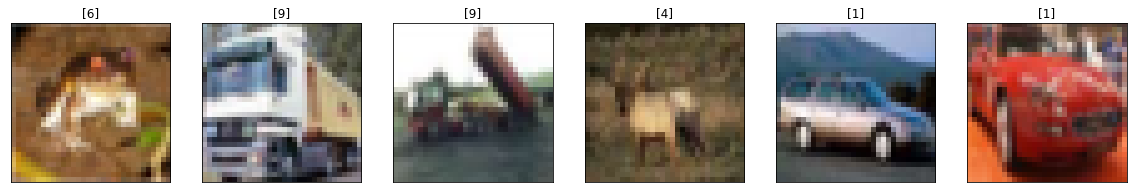

In [6]:
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# plot first six training images
fig = plt.figure(figsize=(20, 20))
for i in range(6):
  ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i], cmap='gray')
  ax.set_title(str(y_train[i]))

In [0]:
num_classes = 10

def load_cifar10_data(img_rows, img_cols):
  # Load cifar10 training and validation sets
  (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

  # Resize training images
  X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
  X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

  # Transform targets to keras compatible format
  Y_train = to_categorical(Y_train, num_classes)
  Y_valid = to_categorical(Y_valid, num_classes)
  
  X_train = X_train.astype('float32')
  X_valid = X_valid.astype('float32')

  # preprocess data
  X_train = X_train / 255.0
  X_valid = X_valid / 255.0

  return X_train, Y_train, X_valid, Y_valid

In [0]:
X_train, y_train, X_test, y_test = load_cifar10_data(224, 224)

### Visualize the First Six Training Images

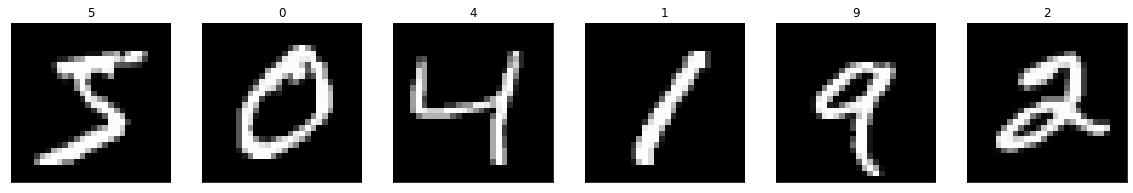

In [0]:
%matplotlib inline
import matplotlib.cm as cm

# plot first six training images
fig = plt.figure(figsize=(20, 20))
for i in range(6):
  ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i], cmap='gray')
  ax.set_title(str(y_train[i]))

### Preprocess input images

We will rescale the Images by Dividing Every Pixel in Every Image by 255.

In [0]:
# normalize the data to accelerate learning
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

print(f'X_train shape: {X_train.shape}')
print(f'{X_train.shape[0]} train samples')
print(f'{X_test.shape[0]} test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


### Preprocess the labels

We will encode categorical integer labels using a One-Hot scheme.

In [0]:
from tensorflow.keras.utils import to_categorical

num_classes = 10

# print first ten (integer-valued) training labels
print(f'Integer-valued labels:\n{y_train[:10]}')

# one-hot encode the labels
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# print first ten (one-hot) training labels
print(f'One-hot labels:\n{y_train[:10]}')

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Reshape data to fit our CNN (and input_shape)

In [0]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
# input image dimensions 28x28 pixel images.
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

print(f'image input shape: {input_shape}')
print(f'x_train shape: {X_train.shape}')
print(f'x_test shape: {X_test.shape}')

image input shape: (28, 28, 1)
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


## Define the Model Architecture

In [0]:
model = keras.models.Sequential()

# C1 Convolutional Layer
model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding='same'))

# S2 Pooling Layer
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C3 Convolutional Layer
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# S4 Pooling Layer
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# Flatten the CNN output so that we can connect it with fully connected layers
model.add(keras.layers.Flatten())

# FC6 Fully Connected Layer
model.add(keras.layers.Dense(84, activation='tanh'))

# Output Layer with softmax activation
model.add(keras.layers.Dense(10, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 84)                1

LeNet-5 is a small neural network with today’s standards. It has 61,706 parameters compared to millions of parameters in more modern networks.

### Compile the Model

The loss function is categorical cross entropy since we have multiple classes (10).

So compile the model by defining the loss function, optimizer, and performance metric

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), 
                    callbacks=[checkpointer], verbose=2, shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.07105, saving model to model.weights.best.hdf5
60000/60000 - 37s - loss: 0.1847 - accuracy: 0.9449 - val_loss: 0.0711 - val_accuracy: 0.9788
Epoch 2/20

Epoch 00002: val_loss improved from 0.07105 to 0.04931, saving model to model.weights.best.hdf5
60000/60000 - 37s - loss: 0.0648 - accuracy: 0.9801 - val_loss: 0.0493 - val_accuracy: 0.9845
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.04931
60000/60000 - 38s - loss: 0.0470 - accuracy: 0.9856 - val_loss: 0.0555 - val_accuracy: 0.9834
Epoch 4/20

Epoch 00004: val_loss improved from 0.04931 to 0.04312, saving model to model.weights.best.hdf5
60000/60000 - 37s - loss: 0.0366 - accuracy: 0.9884 - val_loss: 0.0431 - val_accuracy: 0.9865
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.04312
60000/60000 - 37s - loss: 0.0302 - accuracy: 0.9901 - val_loss: 0.0487 - val_accuracy: 0.9834
Epoch 6/20

Epoch 00006: val_loss 

## Evaluate the model

Load the Model with the Best Classification Accuracy on the Validation Set

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

Calculate the Classification Accuracy on the Test Set

In [0]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100 * score[1]
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 98.8500%


Plot accuracy/loss per epoch

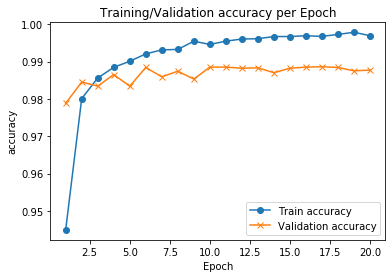

In [0]:
f, ax = plt.subplots()
ax.plot([None] + history.history['accuracy'], 'o-')
ax.plot([None] + history.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train accuracy', 'Validation accuracy'], loc = 0)
ax.set_title('Training/Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('accuracy')
plt.show()

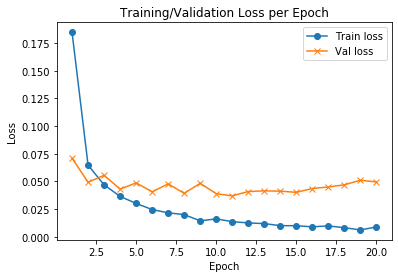

In [0]:
f, ax = plt.subplots()
ax.plot([None] + history.history['loss'], 'o-')
ax.plot([None] + history.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', "Val loss"], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

## LeNet performance on MNIST dataset

When you train LeNet-5 on the MNIST dataset you will get above 99% accuracy.

Try to re-run this experiment with ‘relu’ activation function in the hidden layers and observe the difference in the network performance.

In [0]:
model = keras.models.Sequential()

# C1 Convolutional Layer
model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same'))

# S2 Pooling Layer
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C3 Convolutional Layer
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))

# S4 Pooling Layer
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))

# Flatten the CNN output so that we can connect it with fully connected layers
model.add(keras.layers.Flatten())

# FC6 Fully Connected Layer
model.add(keras.layers.Dense(84, activation='relu'))

# Output Layer with softmax activation
model.add(keras.layers.Dense(10, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath='model.weights.best2.hdf5', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), 
                    callbacks=[checkpointer], verbose=2, shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.05844, saving model to model.weights.best2.hdf5
60000/60000 - 39s - loss: 0.1877 - accuracy: 0.9426 - val_loss: 0.0584 - val_accuracy: 0.9813
Epoch 2/20

Epoch 00002: val_loss improved from 0.05844 to 0.05072, saving model to model.weights.best2.hdf5
60000/60000 - 38s - loss: 0.0629 - accuracy: 0.9813 - val_loss: 0.0507 - val_accuracy: 0.9845
Epoch 3/20

Epoch 00003: val_loss improved from 0.05072 to 0.03793, saving model to model.weights.best2.hdf5
60000/60000 - 38s - loss: 0.0452 - accuracy: 0.9853 - val_loss: 0.0379 - val_accuracy: 0.9877
Epoch 4/20

Epoch 00004: val_loss improved from 0.03793 to 0.03446, saving model to model.weights.best2.hdf5
60000/60000 - 37s - loss: 0.0359 - accuracy: 0.9883 - val_loss: 0.0345 - val_accuracy: 0.9883
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.03446
60000/60000 - 38s - loss: 0.0298 - accuracy: 0.9903 - val_loss: 0.0489 - val_ac

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best2.hdf5')

In [0]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100 * score[1]
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.0300%


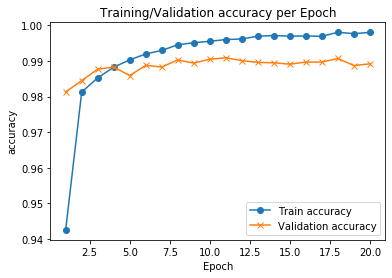

In [0]:
f, ax = plt.subplots()
ax.plot([None] + history.history['accuracy'], 'o-')
ax.plot([None] + history.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train accuracy', 'Validation accuracy'], loc = 0)
ax.set_title('Training/Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('accuracy')
plt.show()

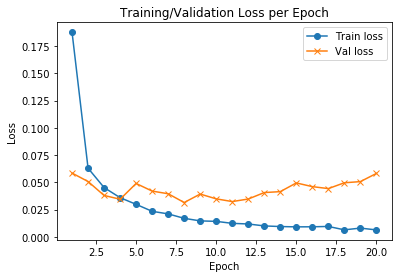

In [0]:
f, ax = plt.subplots()
ax.plot([None] + history.history['loss'], 'o-')
ax.plot([None] + history.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', "Val loss"], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()